# Engagement Test
Many sites make money by selling ads, and for these sites, the number of pages visted by users on each session is one of the most important metric.

It is often data scientist responsibility to analyze test data and understand whether the model has been successful. Goal of this challenge is to look at A/B test results and draw conclusions.

A social network company has added a new feature called *Recommended Friends*, suggesting people you may know. The feature suggests 5 friends to each user, and the model is tested on a random subset of users to see how it performs compared to users without the feature.

The test has been running for a while, and you are asked to check, for each user, the number of pages visited during their first session since the test started. If the number increased, the test is success.

Specifically, the goals of this challenge are the following:

* Is the A/B test winning? That is, should 100% of the users ses the recommended friends feature?
* Is the test performing similarly for all user segments or are there differences among different segments?
* If you identified segments that responded differently to the test, can you guess the reason? Would this change your point 1 conclusions?

*Challenge completed by: Ryan Bae*

*Completion date: 10/08/2017*

## Initial Data Exploration and Visualization
First we start by importing necessary Python packages and the dataset.

In [105]:
# import Python packages
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import Ridge 

In [2]:
# import data
test = pd.read_csv("test_table.csv")
user = pd.read_csv("user_table.csv")

Let's take a quick summary look at the dataset.

In [3]:
test.describe()

,user_id,test,pages_visited
count,1.000000e+05,100000.00000,100000.000000
mean,4.511960e+06,0.50154,4.604030
std,2.596973e+06,0.50000,2.467845
min,3.400000e+01,0.00000,0.000000
25%,2.271007e+06,0.00000,3.000000
50%,4.519576e+06,1.00000,5.000000
75%,6.764484e+06,1.00000,6.000000
max,8.999849e+06,1.00000,17.000000


In [4]:
user.describe()

,user_id
count,1.000000e+05
mean,4.511960e+06
std,2.596973e+06
min,3.400000e+01
25%,2.271007e+06
50%,4.519576e+06
75%,6.764484e+06
max,8.999849e+06


We see 100000 users in both tables. The average number of pages a user visits is around 4.6, with standard deviation of around 2.5. About half of the users were tested, meaning they had the Recommended Friends features on their newsfeed. 

In [5]:
user.describe(include=[np.object])

,signup_date
count,100000
unique,243
top,2015-08-19
freq,758


In [6]:
user.head(5)

,user_id,signup_date
0,34,2015-01-01
1,59,2015-01-01
2,178,2015-01-01
3,285,2015-01-01
4,383,2015-01-01


In [7]:
test.head(5)

,user_id,date,browser,test,pages_visited
0,600597,2015-08-13,IE,0,2
1,4410028,2015-08-26,Chrome,1,5
2,6004777,2015-08-17,Chrome,0,8
3,5990330,2015-08-27,Safari,0,8
4,3622310,2015-08-07,Firefox,0,1


In [8]:
test.describe(include=[np.object])

,date,browser
count,100000,100000
unique,31,5
top,2015-08-19,Chrome
freq,3710,43427


Here we see that the sign up dates for the users vary from Janary to August of 2015. There are 243 unique sign up dates, which means most users have overlapping sign up dates.

Also, the most frequent browse is Chrome, and it accounts for about 43% of the browser types. Let's take a closer look at the features in both tables.

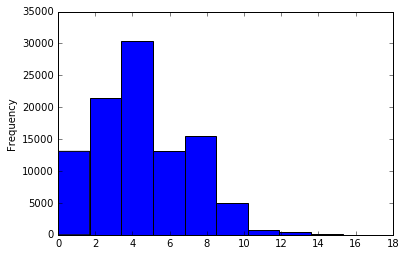

In [9]:
test["pages_visited"].plot.hist()

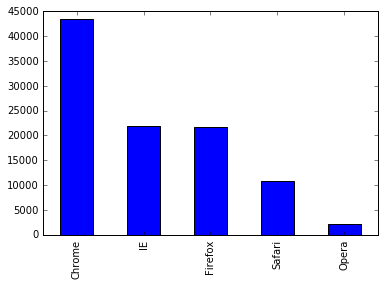

In [10]:
test["browser"].value_counts().plot("bar")

## Data Engineering
Now we do some data engineering. We need to join the two tables by userid, then figure out a way to properly come up with a features (or features) that can make sense of the time data (login date, sign up date, etc).

In [13]:
# join the two tables on userid
data = pd.merge(user, test, how="inner", on="user_id")

In [14]:
data.head()

,user_id,signup_date,date,browser,test,pages_visited
0,34,2015-01-01,2015-08-15,Chrome,0,6
1,59,2015-01-01,2015-08-12,Chrome,1,6
2,178,2015-01-01,2015-08-10,Safari,1,3
3,285,2015-01-01,2015-08-03,Opera,0,5
4,383,2015-01-01,2015-08-05,Firefox,1,9


In [15]:
print "Merged table length: ", len(data)

Merged table length:  100000


Let's quickly compare the mean **pages_visted** values between test and control groups to see if we are seeing more pages being visited.

In [108]:
# independent t-test function 
def run_ttest(df):
    test_group = df[df["test"] == 1]["pages_visited"]
    control_group = df[df["test"] == 0]["pages_visited"]
    test_mean = test_group.mean()
    control_mean = control_group.mean()
    
    result = ss.ttest_ind(control_group, test_group, equal_var=False)
    conclusion = "Significant" if result.pvalue < 0.05 else "Not Significant"
    
    return pd.Series({"n_test": test_group.shape[0],
                      "n_control": control_group.shape[0],
                      "mean_test": test_mean,
                      "mean_control": control_mean,
                      "p_value": result.pvalue,
                      "conclusion": conclusion
                     })

In [111]:
run_ttest(data).to_frame().reset_index()

,index,0
0,conclusion,Not Significant
1,mean_control,4.60839
2,mean_test,4.59969
3,n_control,49846
4,n_test,50154
5,p_value,0.577452


* Is the A/B test winning? That is, should 100% of the users ses the recommended friends feature?

***To answer the first question, the difference between the test and control group in pages visited is NOT statistically significant. At first glance, it seems like the test is NOT winning, and therefore should be stopped.***

But we have to look closer at the data to confirm our t-test results. Let's take a look at the time data. A better feature to look at for our model is number of days a user has been using the social media site. It is simply the difference between the test date and the sign up date.

In [16]:
# first change the signup_date and date columns into pandas datetime 
data["date"] = pd.to_datetime(data["date"])
data["date"] = data["date"].dt.date
data["signup_date"] = pd.to_datetime(data["signup_date"])
data["signup_date"] = data["signup_date"].dt.date

# these checks should print pandas timestamp class
print type(data["date"][0])
print type(data["signup_date"][0])
data["date"].head(5)

<type 'datetime.date'>
<type 'datetime.date'>


0    2015-08-15
1    2015-08-12
2    2015-08-10
3    2015-08-03
4    2015-08-05
Name: date, dtype: object

In [17]:
# take the difference between the two dates
data["account_age"] = data["date"] - data["signup_date"]
data["account_age"] = data["account_age"].dt.days
data["account_age"].head(5).to_frame()

,account_age
0,226
1,223
2,221
3,214
4,216


Let's take a quick moment to explore and visualize this new feature.

In [18]:
data["account_age"].describe()

count    100000.000000
mean         97.020210
std          73.627085
min           0.000000
25%          29.000000
50%          94.000000
75%         161.000000
max         242.000000
Name: account_age, dtype: float64

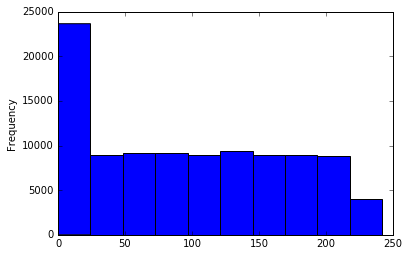

In [19]:
data["account_age"].plot.hist()

In [104]:
print "Most Frequent Account Age: ", data["account_age"].value_counts().idxmax(), " Days"
print "Number of Occurances: ", data["account_age"].value_counts().max()

Most Frequent Account Age:  0  Days
Number of Occurances:  20001


The histogram of account age shows big jump for accounts less than 25 days old. When we look closer, it becomes clear that most of it is due to accounts created that day (0 days old). Therefore, it makes more sense to change our **account_age** feature to a binary categorical feature, where the user is new or old. 

Most other account ages are evenly distributed between 25 to 225 days old. 

In [117]:
# change feature to new user or old user
data["new_user"] = data["account_age"].apply(lambda x: 1 if x == 0 else 0)

# should be 20001
print len(data[data["new_user"]==1])
data.head(5)

20001


,user_id,signup_date,date,browser,test,pages_visited,account_age,new_user
0,34,2015-01-01,2015-08-15,Chrome,0,6,226,0
1,59,2015-01-01,2015-08-12,Chrome,1,6,223,0
2,178,2015-01-01,2015-08-10,Safari,1,3,221,0
3,285,2015-01-01,2015-08-03,Opera,0,5,214,0
4,383,2015-01-01,2015-08-05,Firefox,1,9,216,0


In [135]:
# get rid of unnecessary columns
features = ["test","pages_visited","new_user","browser"]
data = data[features]
data.head(5)

,test,pages_visited,new_user,browser
0,0,6,0,Chrome
1,1,6,0,Chrome
2,1,3,0,Safari
3,0,5,0,Opera
4,1,9,0,Firefox


## More Data Exploration
Now that we have completed the data engineering portion, let's take a deeper look at the data set to see if the difference in mean values of pages_visted for different user segments are statistically significant.

We will start with the newly created **new_user** feature.

In [118]:
# run independent t-test on new_user column
data[features].groupby("test").mean().reset_index()

,test,pages_visited,new_user
0,0,4.608394,0.199735
1,1,4.599693,0.200283


In [133]:
data.groupby("new_user").apply(run_ttest)

,conclusion,mean_control,mean_test,n_control,n_test,p_value
new_user,,,,,,
0,Not Significant,4.603284,4.622379,39890,40109,0.261837
1,Significant,4.628867,4.509109,9956,10045,0.001742


Interesting! The p-value for new users show a statistically significant result, while the p-value for non new users did not. This is an intersting insight. Let's now take a look the different browsers.

In [136]:
# run independent t-test on browswer column
data[features].groupby("browser").mean().reset_index()

,browser,test,pages_visited,new_user
0,Chrome,0.505999,4.652474,0.202869
1,Firefox,0.495726,4.656724,0.195744
2,IE,0.501554,4.642367,0.199132
3,Opera,0.478608,2.370475,0.193230
4,Safari,0.499815,4.665248,0.200222


Each browser had about 50/50 test/non-test users. The account age shows slighly more variation, although it looks statistically insignificant.

However, users who used Opera browser (which was the least represented browser among users) visited significantly smaller number of pages than other browser users. The difference is huge, with more than 2 less pages visted on average!

Let's take a closer look. 

In [138]:
data.groupby(["browser","test"]).mean().reset_index()

,browser,test,pages_visited,new_user
0,Chrome,0,4.613341,0.203282
1,Chrome,1,4.690680,0.202467
2,Firefox,0,4.600164,0.194131
3,Firefox,1,4.714259,0.197385
4,IE,0,4.598478,0.198240
5,IE,1,4.685985,0.200018
6,Opera,0,4.546438,0.203787
7,Opera,1,0.000000,0.181729
8,Safari,0,4.638180,0.199223
9,Safari,1,4.692336,0.201222


In [137]:
data.groupby("browser").apply(run_ttest)

,conclusion,mean_control,mean_test,n_control,n_test,p_value
browser,,,,,,
Chrome,Significant,4.613341,4.690680,21453,21974,9.434084e-04
Firefox,Significant,4.600164,4.714259,10972,10786,5.817199e-04
IE,Significant,4.598478,4.685985,10906,10974,7.829509e-03
Opera,Significant,4.546438,0.000000,1109,1018,2.252939e-321
Safari,Not Significant,4.638180,4.692336,5406,5402,2.411738e-01


Woah! Opera users who got the test page has mean value of pages_visited of 0! This is highly unlikely result, as the chance of tens of thousands of users on Opera not visiting *any* pages is next to nothing. This seems to suggest an error with data collection or the A/B test itself. 

All the other browsers show statistically significant increases in the visted pages mean value. This tells me that the test is running successfully, at least on the other browsers.

* Is the test performing similarly for all user segments or are there differences among different segments?

***The test is NOT performing similarly for all user segments. The Opera browser users that are shown the test feature show mean value of visted pages as 0. Safari users are also not seeing a statistically significant improvement. Finally, new users see a statistically significant decrease in the average number of pages visited.*** 

* If you identified segments that responded differently to the test, can you guess the reason? Would this change your point 1 conclusions?

***There seems to be a bug with the Opera browser roll out of the A/B test, and users' number of visited pages are not being recorded. We have to get rid of the Opera browser data from the dataframe and re-perform the t-test. Most other browsers showed a statistically significant difference in mean value of pages visited, the redone overall test should do so as well. This changes the conclusion from point 1.***

***For Safari users, the result could be due to some Safari specific feature that is interfering with the recommended friends product. For example, Safari browser could hide the new friends recommendations because of its browser layout.***

***Regarding the decrease in traffic from new users, it could be that the new users simply do not have a large enough network yet to suggest 5 relevant new friends. Therefore, the new feature has little effect on new users, and if anything, scares them away from the website due to too much information. It is recommended that new users be not shown this recommended friends features right away.***

In [142]:
# re-perform the t-test without Opera browser data
data = data[data["browser"] != "Opera"]
run_ttest(data)

conclusion      Significant
mean_control         4.6098
mean_test           4.69499
n_control             48737
n_test                49136
p_value         4.40395e-08
dtype: object

And indeed, we see a statistically significant result after the Opera browser results have been removed. 

## More Data Visualization (OPTIONAL)

Visualization of browser types.

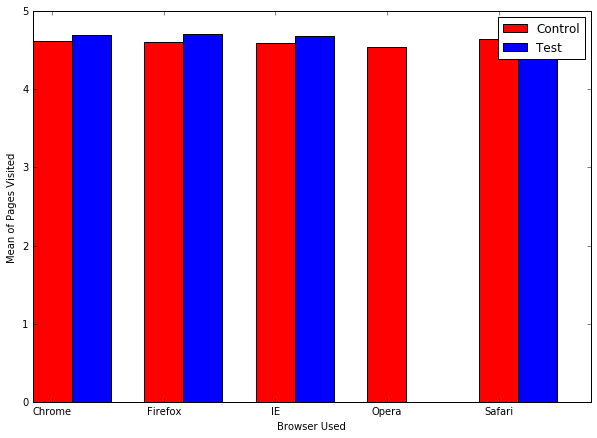

In [23]:
## plot above in matplotlib with Opera data

# divide data into test and control and extract pages_visited 
control = data[data["test"]==0]
testing = data[data["test"]==1]
control_mean = control.groupby("browser").mean()
control_mean = control_mean["pages_visited"]
test_mean = testing.groupby("browser").mean()
test_mean = test_mean["pages_visited"]

# set labels and width
browsers = sorted(data["browser"].unique())
ind = np.arange(len(browsers))
width = 0.35

# plot figure
fig, ax = plt.subplots(figsize=(10,7))
control_bars = ax.bar(ind, control_mean, width, color='r')
test_bars = ax.bar(ind+width, test_mean, width, color='b')

# axis 
ax.set_xlabel('Browser Used')
ax.set_ylabel('Mean of Pages Visited')
ax.set_xticks(ind+width/2)
ax.set_xticklabels(browsers)
ax.legend((control_bars[0], test_bars[0]),('Control','Test'))

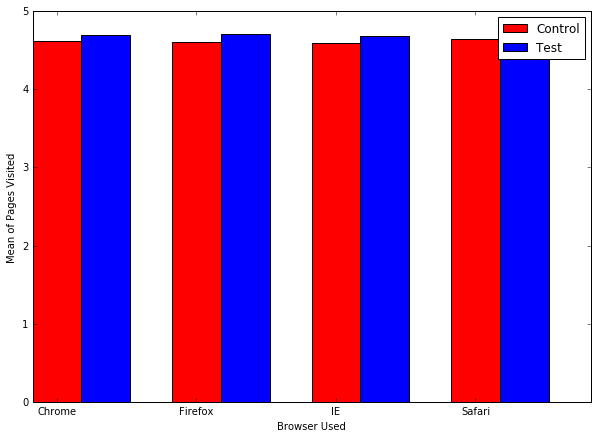

In [24]:
## plot above in matplotlib without Opera data
data_noop = data[data["browser"] != "Opera"]

# divide data into test and control and extract pages_visited 
control = data_noop[data_noop["test"]==0]
testing = data_noop[data_noop["test"]==1]
control_mean = control.groupby("browser").mean()
control_mean = control_mean["pages_visited"]
test_mean = testing.groupby("browser").mean()
test_mean = test_mean["pages_visited"]

# set labels and width
browsers = sorted(data_noop["browser"].unique())
ind = np.arange(len(browsers))
width = 0.35

# plot figure
fig, ax = plt.subplots(figsize=(10,7))
control_bars = ax.bar(ind, control_mean, width, color='r')
test_bars = ax.bar(ind+width, test_mean, width, color='b')

# axis 
ax.set_xlabel('Browser Used')
ax.set_ylabel('Mean of Pages Visited')
ax.set_xticks(ind+width/2)
ax.set_xticklabels(browsers)
ax.legend((control_bars[0], test_bars[0]),('Control','Test'))

## Machine Learning (OPTIONAL)
Let's build a regression model and see if we can use the coefficient values to confirm our findings above. This is optional exercise for the purpose of practice. 

Since the variable to predict here is numeric, we use a regression model. Because the Opera data is considered unreliable from the initial data exploration, we use the data set without the Opera users. 

We fit **ridge regularized regression (L2 norm)** model. We picked Ridge regression because the data set is not particularly high dimensional (there's only few features), and so feature reduction is not a problem. 

In [143]:
data.head(5)

,test,pages_visited,new_user,browser
0,0,6,0,Chrome
1,1,6,0,Chrome
2,1,3,0,Safari
4,1,9,0,Firefox
5,0,1,0,IE


We one-hot encode the data to prepare it for the regression algorithm.

In [145]:
# one hot encoding
data_en = pd.get_dummies(data)
data_en.head(5)

,test,pages_visited,new_user,browser_Chrome,browser_Firefox,browser_IE,browser_Safari
0,0,6,0,1.0,0.0,0.0,0.0
1,1,6,0,1.0,0.0,0.0,0.0
2,1,3,0,0.0,0.0,0.0,1.0
4,1,9,0,0.0,1.0,0.0,0.0
5,0,1,0,0.0,0.0,1.0,0.0


In [146]:
# split into train and test sets
train = data_en.sample(frac=0.8, random_state=1)
test = data_en.drop(train.index)

x_train = train.drop("pages_visited", 1)
y_train = train["pages_visited"]
x_test = test.drop("pages_visited", 1)
y_test = test["pages_visited"]

# output to check
print "Training set length: ", len(train)
print "Testing set length: ", len(test)
x_train.head(5)

Training set length:  78298
Testing set length:  19575


,test,new_user,browser_Chrome,browser_Firefox,browser_IE,browser_Safari
83630,1,1,0.0,1.0,0.0,0.0
88237,0,1,0.0,1.0,0.0,0.0
84295,1,1,1.0,0.0,0.0,0.0
19601,1,0,0.0,1.0,0.0,0.0
10663,1,0,0.0,0.0,1.0,0.0


Finally, we can fit the model and check the results.

In [155]:
# fit model
ridge = Ridge(alpha = 1, fit_intercept=True)
ridge_model = ridge.fit(x_train, y_train)

In [159]:
# get score and coefficients
print "Training Set R^2 Value: ", ridge_model.score(x_train, y_train), "\n"
features = x_train.columns
inds = np.argsort(ridge_model.coef_)
coefs = sorted(ridge_model.coef_, reverse=True)

print "COEFFICIENTS"
for i in range(len(features)):
    print features[i], ": ", ridge_model.coef_[i]

Training Set R^2 Value:  0.000498040871728 

COEFFICIENTS
test :  0.0952248213817
new_user :  -0.0636469419574
browser_Chrome :  0.00146473702137
browser_Firefox :  -0.00163468615074
browser_IE :  -0.0111207026482
browser_Safari :  0.0112906517598


In [150]:
# compute RMSE on training set
y_train_pred = ridge_model.predict(x_train)
training_err = y_train - y_train_pred
total_err = np.dot(training_err, training_err)
rmse_train = np.sqrt(total_err/len(y_train))
print "RMSE Training Error: %.4f" %rmse_train

RMSE Training Error: 2.4340


In [151]:
# predict on test set
y_test_pred = ridge_model.predict(x_test)
test_err = y_test - y_test_pred
total_err = np.dot(test_err, test_err)
rmse_test = np.sqrt(total_err/len(y_test))
print "RMSE Test Error: %.4f" % rmse_test

RMSE Test Error: 2.4224


And we indeed see that the test has positive effect on the **pages_visited** feature. We also see that being a new user has a negative coefficient, agreeing with our findings earlier about a statistically significant drop off in **pages_visited** average.